In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [ ]:
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rc('font', family='DejaVu Serif')

<ipython-input-5-47206b08e5e4>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Attack success rate

In [ ]:
data = pd.read_csv("/content/dissertation_results2.csv")

In [ ]:
data.head()

,Dataset,prompt_type,trigger_type,insert_pos,poison_ratio,K,num_trigger,score_mean,score_std,asr_l0_mean,asr_l0_std,asr_l1_mean,asr_l1_std,asr_l2_mean,asr_l2_std
0,QNLI,Auto,None,Start,0.5,16,6,0.53374,0.013,0.56668,0.152,0.62110,0.140,NaN,NaN
1,QNLI,Auto,None,Start,0.5,100,6,0.74031,0.043,0.45940,0.120,0.36440,0.091,NaN,NaN
2,QNLI,Auto,None,Start,0.5,1000,6,0.83240,0.038,0.48410,0.124,0.12657,0.056,NaN,NaN
3,QNLI,Auto,Visible,Start,0.5,16,6,0.51604,0.013,1.00000,0.000,0.00069,0.001,NaN,NaN
4,QNLI,Auto,Visible,Start,0.5,100,6,0.72037,0.045,0.94433,0.111,0.97059,0.048,NaN,NaN


In [ ]:
def get_standard_df(dataset_name):
  return data[(data['Dataset'] == dataset_name) & (data['trigger_type'] != 'Invisible') & (data['insert_pos'] == 'Start') & (data['poison_ratio'] == 0.5) & (data['num_trigger'] == 6)]
sst2_standard = get_standard_df("SST2")
qnli_standard = get_standard_df("QNLI")
tweets_ho_standard = get_standard_df("TWEETS-HATE-OFFENSIVE")
mnli_m_standard = get_standard_df("MNLI-MATCHED")
mnli_mis_standard = get_standard_df("MNLI-MISMATCHED")
enron_spam_standard = get_standard_df("ENRON-SPAM")

In [ ]:
# compute ACC(delta)
def calc_acc_delta(df):
  score_mean = np.array(df['score_mean']).reshape(-1,3)
  return np.diff(score_mean, axis=0).flatten() * 100
  
# compute std for ACC(delta)
def calc_std_acc_delta(df):
  score_std = np.array(df['score_std']).reshape(-1,3)
  return np.sqrt(np.sum(np.power(score_std,2), axis=0)) * 100

# series to arrays in percentage
def transform(df, col):
  return np.array(df[col]).reshape(-1, 3) * 100

In [ ]:
def plot_backdoor_acc(dataset_name, metrics, df_mean_list, df_std_list, df_asr_mean_map, df_asr_std_map):
  num = len(df_mean_list)
  num_class = len(df_asr_mean_map)
  model_names = ["Poisoned Manual", "Poisoned Auto", "Poisoned Diff"]
  colors=['#984ea3', '#ff7f00', '#4daf4a']
  k = np.array([16, 100, 1000])
  fig,ax = plt.subplots(2,1)
  ax[0].axhline(y = 0, color = 'grey', linestyle = 'dotted', label="Unpoisoned M/A/D")
  for idx, df in enumerate(df_mean_list):
    df_std = df_std_list[idx]
    ax[0].plot(np.log(k), df, label=model_names[idx], color=colors[idx])
    ax[0].fill_between(np.log(k), df + df_std, df - df_std, alpha=0.15, color=colors[idx])
  width = 0.1
  start_p = 3 * num_class * width / 2 - 0.1
  for label, df_list in df_asr_mean_map.items():
    df_std_list = df_asr_std_map[label]
    for idx, df in enumerate(df_list):
      if label == num_class - 1:
        ax[1].bar(np.log(k)-start_p+width*label+width*num_class*idx, df[1],alpha=0.6, color=colors[idx],width=0.1, label=model_names[idx])
        if idx == 0:
          ax[1].bar(np.log(k)-start_p+width*label+width*num_class*idx, df[0], alpha=0.6, color='grey',width=0.1, label="Unpoisoned M/A/D")
      else:
        ax[1].bar(np.log(k)-start_p+width*label+width*num_class*idx, df[1],alpha=0.6, color=colors[idx],width=0.1)
        ax[1].bar(np.log(k)-start_p+width*label+width*num_class*idx, df[0], alpha=0.6, color='grey',width=0.1)
  arr = np.mean(np.array([np.array(df_asr_mean_map[label]) for label in range(num_class)]), axis=0)
  arr2 = np.array([arr[i][1] for i in range(3)])
  pos_list = [[np.log(i)-start_p+(m+1/4)*width*num_class for i in k] for m in range(3)]
  for i,l in enumerate(arr2):
    ax[1].plot(pos_list[i], l, color=colors[i], linestyle="--", label=f"avg. {model_names[i]}")

  ax[0].set_ylabel(f"Mean {metrics} Δ", weight="bold")
  ax[0].set_title(f"Visible Backdoor Attacks On {dataset_name}", weight="bold")
  if dataset_name in ["ENRON-SPAM", "TWEETS-HATE-OFFENSIVE"]:
    ax[0].legend(loc='lower right', ncol=2, fancybox=True, fontsize=8)
  elif dataset_name in ["MNLI-MATCHED", "MNLI-MISMATCHED"]:
    ax[0].legend(loc='upper left', ncol=2, fancybox=True, fontsize=8)
  else:
    ax[0].legend(loc='lower center', ncol=2, fancybox=True, fontsize=8)
  ax[0].set_xticks([])
  ax[1].set_xticklabels(['16', '100', '1000'])
  ax[1].set_xlabel("K samples per class", weight="bold")
  ax[1].set_ylabel(f"Mean ASR (L0~L{num_class-1})", weight="bold")
  ax[1].set_xticks([np.log(i) for i in k])
  ax[1].set_ylim([-5, 102])
  ax[1].set_yticks([0, 20, 40, 60, 80, 100])
  ax[1].legend(loc='lower center', ncol=4, fancybox=True, bbox_to_anchor=(0.5, -0.55), fontsize=8)
  plt.tight_layout()
  plt.savefig(f"{dataset_name}_score_n_attack.svg")
  plt.savefig(f"{dataset_name}_score_n_attack.pdf")

In [ ]:
def plot_util(df, dataset_name, metrics, num_classes):
  df_manual = df[df['prompt_type'] == 'Manual']
  df_auto = df[df['prompt_type'] == 'Auto']
  df_diff = df[df['prompt_type'] == 'Diff']
  dfs = [df_manual, df_auto, df_diff]

  df_mean_list = []
  df_std_list = []
  df_asr_mean_map = {k:[] for k in range(num_classes)}
  df_asr_std_map = {k:[] for k in range(num_classes)}

  for df in dfs:
    df_mean_list.append(calc_acc_delta(df))
    df_std_list.append(calc_std_acc_delta(df))

  for idx in range(num_classes):
    l_asr_mean = df_asr_mean_map[idx]
    l_asr_std = df_asr_std_map[idx]
    for df in dfs:
      l_asr_mean.append(transform(df, f'asr_l{idx}_mean'))
      l_asr_std.append(transform(df, f'asr_l{idx}_std'))

  plot_backdoor_acc(dataset_name, metrics, df_mean_list, df_std_list, df_asr_mean_map, df_asr_std_map)

<ipython-input-171-cad38ed34548>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['16', '100', '1000'])


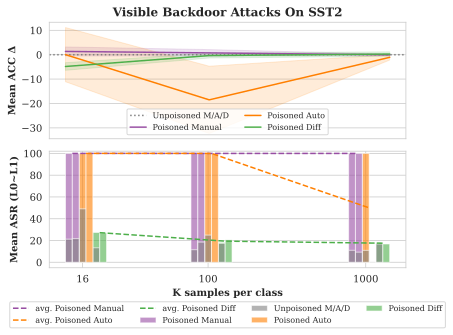

In [ ]:
plot_util(sst2_standard, "SST2", "ACC", 2)

<ipython-input-171-cad38ed34548>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['16', '100', '1000'])


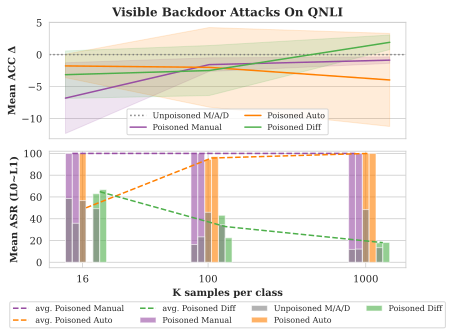

In [ ]:
plot_util(qnli_standard, "QNLI", "ACC", 2)

<ipython-input-171-cad38ed34548>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['16', '100', '1000'])


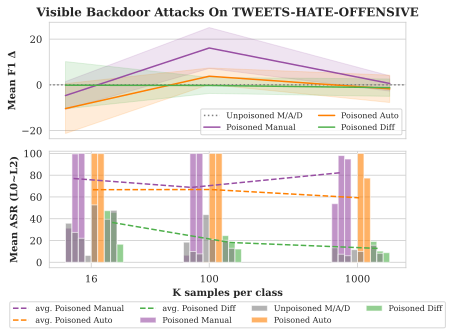

In [ ]:
map = plot_util(tweets_ho_standard, "TWEETS-HATE-OFFENSIVE", "F1", 3)

<ipython-input-171-cad38ed34548>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['16', '100', '1000'])


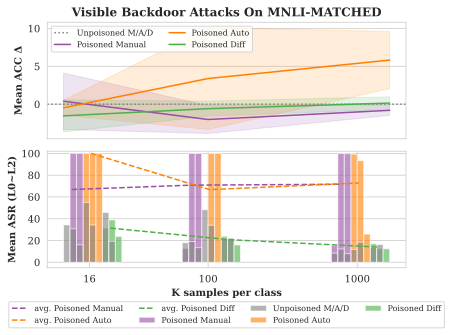

In [ ]:
plot_util(mnli_m_standard, "MNLI-MATCHED", "ACC", 3)

<ipython-input-171-cad38ed34548>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['16', '100', '1000'])


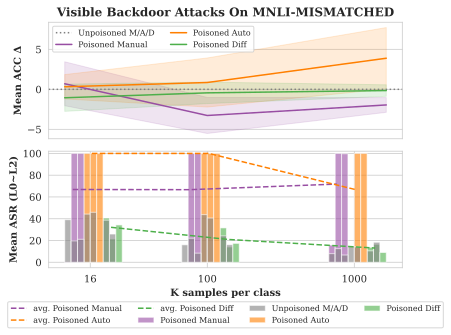

In [ ]:
plot_util(mnli_mis_standard, "MNLI-MISMATCHED", "ACC", 3)

<ipython-input-171-cad38ed34548>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['16', '100', '1000'])


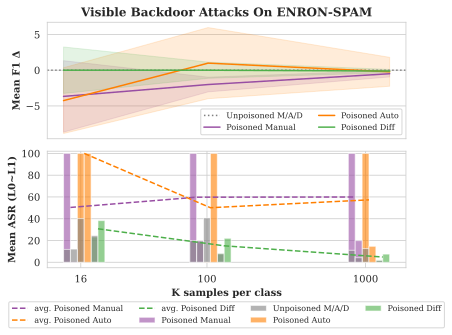

In [ ]:
plot_util(enron_spam_standard, "ENRON-SPAM", "F1", 2)

In [ ]:
def get_num_trigger_df(dataset_name):
  return data[(data['Dataset'] == dataset_name) & (data['trigger_type'] != 'None') & (data['trigger_type'] != 'Invisible') & (data['insert_pos'] == 'Start') & (data['poison_ratio'] == 0.5)]

qnli_num_trigger_df = get_num_trigger_df("QNLI")
tweets_num_trigger_df = get_num_trigger_df("TWEETS-HATE-OFFENSIVE")

In [ ]:
def plot_trigger_num_impacts(standard_df, dataset_name, metrics, num_classes):
  manual_df = standard_df[standard_df['prompt_type'] == 'Manual']
  auto_df = standard_df[standard_df['prompt_type'] == 'Auto']
  diff_df = standard_df[standard_df['prompt_type'] == 'Diff']
  dfs = [manual_df, auto_df, diff_df]
  colors=['grey', '#377eb8', '#984ea3']
  labels=["K=16", "K=100", "K=1000"]
  model_names = ["Poisoned Manual", "Poisoned Auto", "Poisoned Diff"]
  ks = [16, 100, 1000]
  fig,ax = plt.subplots(2,3,sharex=True, sharey=True)
  # x-axis: num_trigger
  num_trigger_list = [1,3,6]
  width = 0.2
  start_p = 3 * num_classes * width / 2 - 0.2
  for idx, df in enumerate(dfs):
    for k_idx, k in enumerate(ks):
      segment = df[df['K'] == k]
      ax[0][idx].plot(segment['num_trigger'], segment['score_mean']* 100, label=labels[k_idx], color=colors[k_idx])
      ax[0][idx].fill_between(segment['num_trigger'], segment['score_mean']* 100 + segment['score_std']* 100, segment['score_mean']* 100 - segment['score_std']* 100, alpha=0.15, color=colors[k_idx])
      for i in range(num_classes):
        if idx == len(dfs)-1 and i == num_classes-1:
          ax[1][idx].bar(segment['num_trigger']-start_p+i*width+k_idx*num_classes*width, segment[f'asr_l{i}_mean']* 100, width=0.2, label=labels[k_idx], color=colors[k_idx])
        else:
          ax[1][idx].bar(segment['num_trigger']-start_p+i*width+k_idx*num_classes*width, segment[f'asr_l{i}_mean']* 100, width=0.2, color=colors[k_idx])
    ax[0][len(dfs)-1].legend(ncol=1, loc='lower right', fontsize=8)
    ax[1][len(dfs)-1].legend(ncol=1, loc='upper right', fontsize=8)
    ax[0][idx].set_title(f"{model_names[idx]}", weight="bold")
    ax[1][idx].set_xlabel("Number of triggers", weight="bold")
    ax[1][idx].set_xticks(num_trigger_list)
    ax[1][idx].set_xticklabels(['1', '3', '6'])
  ax[0][0].set_ylabel(f"Mean {metrics}", weight="bold")
  ax[1][0].set_ylabel(f"Mean ASR(L0~L{num_classes - 1})", weight="bold")
  ax[1][0].set_ylim([-2,100])
  plt.tight_layout()
  plt.savefig(f"{dataset_name}_num_trigger_impacts.svg")
  plt.savefig(f"{dataset_name}_num_trigger_impacts.pdf")

In [ ]:
# using the averaged
def plot_avg_trigger_num_impacts(standard_df, dataset_name, metrics, num_classes):
  manual_df = standard_df[standard_df['prompt_type'] == 'Manual']
  auto_df = standard_df[standard_df['prompt_type'] == 'Auto']
  diff_df = standard_df[standard_df['prompt_type'] == 'Diff']
  dfs = [manual_df, auto_df, diff_df]
  colors=['grey', '#377eb8', '#984ea3']
  labels=["K=16", "K=100", "K=1000"]
  model_names = ["Poisoned Manual", "Poisoned Auto", "Poisoned Diff"]
  ks = [16, 100, 1000]
  fig,ax = plt.subplots(2,3,sharex=True, sharey=True)
  # x-axis: num_trigger
  num_trigger_list = [1,3,6]
  width = 0.2
  start_p = width / 2 - 0.2
  for idx, df in enumerate(dfs):
    for k_idx, k in enumerate(ks):
      segment = df[df['K'] == k]
      ax[0][idx].plot(segment['num_trigger'], segment['score_mean']* 100, label=labels[k_idx], color=colors[k_idx])
      ax[0][idx].fill_between(segment['num_trigger'], segment['score_mean']* 100 + segment['score_std']* 100, segment['score_mean']* 100 - segment['score_std']* 100, alpha=0.15, color=colors[k_idx])
      avg_asr_arr = []
      avg_asr_std_arr = []
      for n in num_trigger_list:
        sample = segment[(segment['num_trigger'] == n)]
        asrs = []
        for i in range(num_classes):
          asrs.append(sample[f'asr_l{i}_mean'] * 100)
        avg_asr_arr.append(np.mean(asrs))
        avg_asr_std_arr.append(np.std(asrs))
      avg_asr_arr = np.array(avg_asr_arr[::-1])
      avg_asr_std_arr = np.array(avg_asr_std_arr[::-1])
      ax[1][idx].bar(segment['num_trigger']+start_p+k_idx*width, avg_asr_arr, width=width, label=labels[k_idx], color=colors[k_idx])
      ax[1][idx].plot(segment['num_trigger']+start_p+k_idx*width, avg_asr_arr, color=colors[k_idx], linestyle="--", alpha=0.3)
      # ax[1][idx].fill_between(segment['num_trigger'], avg_asr_arr + avg_asr_std_arr, avg_asr_arr - avg_asr_std_arr, alpha=0.15, color=colors[k_idx])

    ax[0][len(dfs)-1].legend(ncol=1, loc='lower right', fontsize=8)
    ax[1][len(dfs)-1].legend(ncol=1, loc='upper right', fontsize=8)
    ax[0][idx].set_title(f"{model_names[idx]}", weight="bold")
    ax[1][idx].set_xlabel("Number of triggers", weight="bold")
    ax[1][idx].set_xticks(num_trigger_list)
    ax[1][idx].set_xticklabels(['1', '3', '6'])
  ax[0][0].set_ylabel(f"Mean {metrics}", weight="bold")
  ax[1][0].set_ylabel(f"Mean ASR(L0~L{num_classes - 1})", weight="bold")
  ax[1][0].set_ylim([-2,100])
  plt.tight_layout()
  plt.savefig(f"{dataset_name}_num_trigger_impacts.svg")
  plt.savefig(f"{dataset_name}_num_trigger_impacts.pdf")

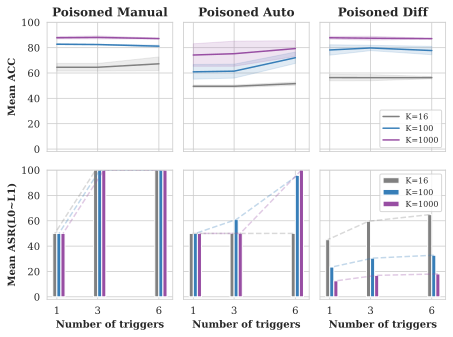

In [ ]:
plot_avg_trigger_num_impacts(qnli_num_trigger_df, "QNLI", "ACC", 2)

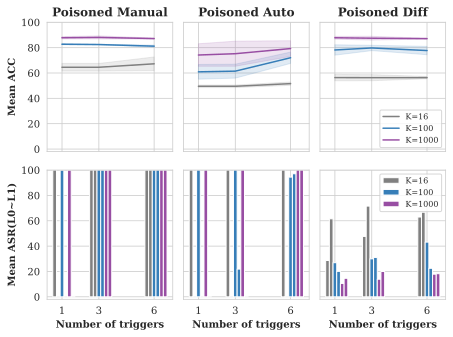

In [ ]:
plot_trigger_num_impacts(qnli_num_trigger_df, "QNLI", "ACC", 2)

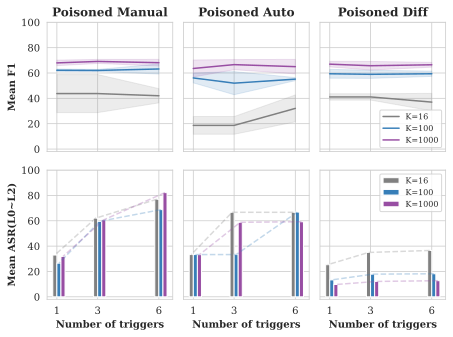

In [ ]:
plot_avg_trigger_num_impacts(tweets_num_trigger_df, "TWEETS-HATE-OFFENSIVE", "F1", 3)

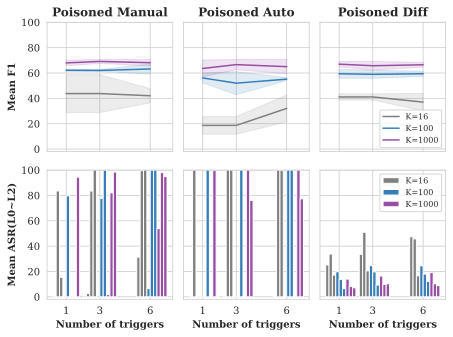

In [ ]:
plot_trigger_num_impacts(tweets_num_trigger_df, "TWEETS-HATE-OFFENSIVE", "F1", 3)

In [ ]:
def get_insert_pos_df(dataset_name):
  return data[(data['Dataset'] == dataset_name) & (data['trigger_type'] != 'None') & (data['trigger_type'] != 'Invisible') & (data['num_trigger'] == 6) & (data['poison_ratio'] == 0.5)]

sst2_insert_pos_df = get_insert_pos_df("SST2")
mnli_matched_insert_pos_df = get_insert_pos_df("MNLI-MATCHED")

In [ ]:
def plot_insert_pos_impacts(standard_df, dataset_name, metrics, num_classes):
  manual_df = standard_df[standard_df['prompt_type'] == 'Manual']
  auto_df = standard_df[standard_df['prompt_type'] == 'Auto']
  diff_df = standard_df[standard_df['prompt_type'] == 'Diff']
  dfs = [manual_df, auto_df, diff_df]
  colors=['grey', '#377eb8', '#984ea3']
  labels=["K=16", "K=100", "K=1000"]
  model_names = ["Poisoned Manual", "Poisoned Auto", "Poisoned Diff"]
  ks = [16, 100, 1000]
  fig,ax = plt.subplots(2,3,sharex=True, sharey=True)
  # x-axis: insert positions
  inser_pos_list = ['Start','Middle','End']
  width = 0.2
  xlist = np.arange(3) * 3
  start_p = 3 * num_classes * width / 2 - 0.2
  for idx, df in enumerate(dfs):
    for k_idx, k in enumerate(ks):
      segment = df[df['K'] == k]
      ax[0][idx].plot(xlist, segment['score_mean']* 100, label=labels[k_idx], color=colors[k_idx])
      ax[0][idx].fill_between(xlist, segment['score_mean']* 100 + segment['score_std']* 100, segment['score_mean']* 100 - segment['score_std']* 100, alpha=0.15, color=colors[k_idx])
      for i in range(num_classes):
        if idx == len(dfs)-1 and i == num_classes-1:
          ax[1][idx].bar(xlist-start_p+i*width+k_idx*num_classes*width, segment[f'asr_l{i}_mean']* 100, width=0.2, label=labels[k_idx], color=colors[k_idx])
        else:
          ax[1][idx].bar(xlist-start_p+i*width+k_idx*num_classes*width, segment[f'asr_l{i}_mean']* 100, width=0.2, color=colors[k_idx])
    ax[0][len(dfs)-1].legend(ncol=1, loc='lower right', fontsize=8)
    ax[1][len(dfs)-1].legend(ncol=1, loc='upper right', fontsize=8)
    ax[0][idx].set_title(f"{model_names[idx]}", weight="bold")
    ax[1][idx].set_xlabel("Insert Trigger", weight="bold")
    ax[1][idx].set_xticks(xlist)
    ax[1][idx].set_xticklabels(['Start', 'Middle', 'End'])
  ax[0][0].set_ylabel(f"Mean {metrics}", weight="bold")
  ax[1][0].set_ylabel(f"Mean ASR(L0~L{num_classes - 1})", weight="bold")
  ax[1][0].set_ylim([-2,100])
  plt.tight_layout()
  plt.savefig(f"{dataset_name}_insert_pos_impacts.svg")
  plt.savefig(f"{dataset_name}_insert_pos_impacts.pdf")

In [ ]:
def plot_avg_insert_pos_impacts(standard_df, dataset_name, metrics, num_classes):
  manual_df = standard_df[standard_df['prompt_type'] == 'Manual']
  auto_df = standard_df[standard_df['prompt_type'] == 'Auto']
  diff_df = standard_df[standard_df['prompt_type'] == 'Diff']
  dfs = [manual_df, auto_df, diff_df]
  colors=['grey', '#377eb8', '#984ea3']
  labels=["K=16", "K=100", "K=1000"]
  model_names = ["Poisoned Manual", "Poisoned Auto", "Poisoned Diff"]
  ks = [16, 100, 1000]
  fig,ax = plt.subplots(2,3,sharex=True, sharey=True)
  # x-axis: insert positions
  inser_pos_list = ['Start','Middle','End']
  width = 0.2
  xlist = np.arange(3) * 3
  width = 0.2
  start_p = width / 2
  for idx, df in enumerate(dfs):
    for k_idx, k in enumerate(ks):
      segment = df[df['K'] == k]
      ax[0][idx].plot(xlist, segment['score_mean']* 100, label=labels[k_idx], color=colors[k_idx])
      ax[0][idx].fill_between(xlist, segment['score_mean']* 100 + segment['score_std']* 100, segment['score_mean']* 100 - segment['score_std']* 100, alpha=0.15, color=colors[k_idx])
      
      avg_asr_arr = []
      avg_asr_std_arr = []
      for n in inser_pos_list:
        sample = segment[(segment['insert_pos'] == n)]
        asrs = []
        for i in range(num_classes):
          asrs.append(sample[f'asr_l{i}_mean'] * 100)
        avg_asr_arr.append(np.mean(asrs))
        avg_asr_std_arr.append(np.std(asrs))
      avg_asr_arr = np.array(avg_asr_arr)
      avg_asr_std_arr = np.array(avg_asr_std_arr)
      ax[1][idx].bar(xlist-start_p+k_idx*width, avg_asr_arr, width=width, label=labels[k_idx], color=colors[k_idx])
      ax[1][idx].plot(xlist-start_p+k_idx*width, avg_asr_arr, color=colors[k_idx], linestyle="--", alpha=0.3)
      
    ax[0][len(dfs)-1].legend(ncol=1, loc='lower right', fontsize=8)
    ax[1][len(dfs)-1].legend(ncol=1, loc='upper right', fontsize=8)
    ax[0][idx].set_title(f"{model_names[idx]}", weight="bold")
    ax[1][idx].set_xlabel("Insert Trigger", weight="bold")
    ax[1][idx].set_xticks(xlist)
    ax[1][idx].set_xticklabels(['Start', 'Middle', 'End'])
  ax[0][0].set_ylabel(f"Mean {metrics}", weight="bold")
  ax[1][0].set_ylabel(f"Mean ASR(L0~L{num_classes - 1})", weight="bold")
  ax[1][0].set_ylim([-2,100])
  plt.tight_layout()
  plt.savefig(f"{dataset_name}_insert_pos_impacts.svg")
  plt.savefig(f"{dataset_name}_insert_pos_impacts.pdf")

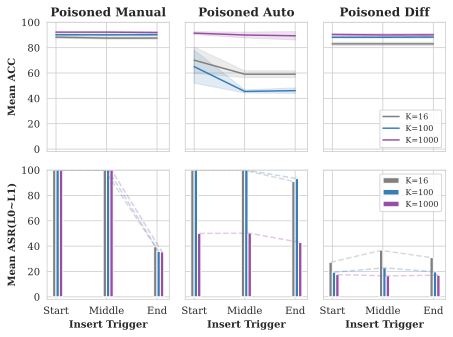

In [ ]:
plot_avg_insert_pos_impacts(sst2_insert_pos_df, "SST2", "ACC", 2)

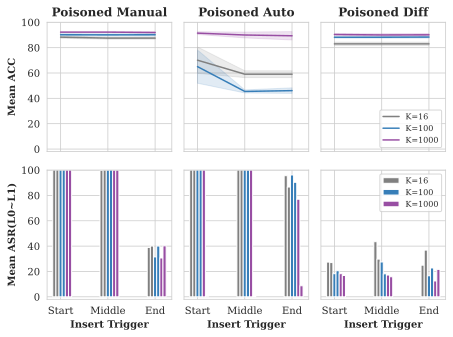

In [ ]:
plot_insert_pos_impacts(sst2_insert_pos_df, "SST2", "ACC", 2)

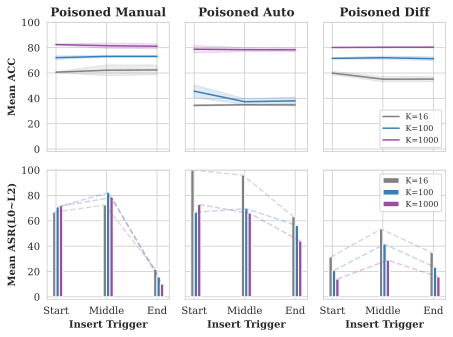

In [ ]:
plot_avg_insert_pos_impacts(mnli_matched_insert_pos_df, "MNLI-MATCHED", "ACC", 3)

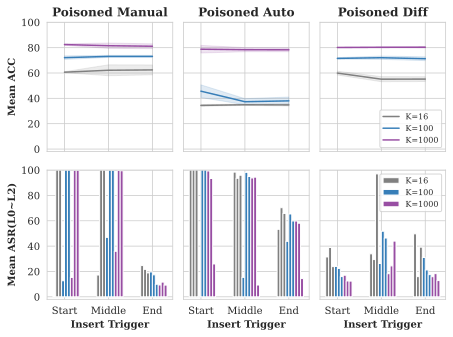

In [ ]:
plot_insert_pos_impacts(mnli_matched_insert_pos_df, "MNLI-MATCHED", "ACC", 3)

In [ ]:
def get_poison_ratio_df(dataset_name):
  return data[(data['Dataset'] == dataset_name) & (data['trigger_type'] != 'None') & (data['trigger_type'] != 'Invisible') & (data['num_trigger'] == 6) & (data['insert_pos'] == 'Start')]

enronspam_poison_ratio_df = get_poison_ratio_df("ENRON-SPAM")
mnli_mismatched_poison_ratio_df = get_poison_ratio_df("MNLI-MISMATCHED")

In [ ]:
def plot_avg_poison_ratio_impacts(standard_df, dataset_name, metrics, num_classes):
  manual_df = standard_df[standard_df['prompt_type'] == 'Manual']
  auto_df = standard_df[standard_df['prompt_type'] == 'Auto']
  diff_df = standard_df[standard_df['prompt_type'] == 'Diff']
  dfs = [manual_df, auto_df, diff_df]
  colors=['grey', '#377eb8', '#984ea3']
  labels=["K=16", "K=100", "K=1000"]
  model_names = ["Poisoned Manual", "Poisoned Auto", "Poisoned Diff"]
  ks = [16, 100, 1000]
  fig,ax = plt.subplots(2,3,sharex=True, sharey=True)
  # x-axis: poison ratio
  poison_ratio_list = [5e-1,5e-2,1e-2,5e-3,1e-3]
  width = 0.25
  xlist = np.arange(5) * 3
  xlist = xlist[::-1]
  start_p = width / 2
  for idx, df in enumerate(dfs):
    for k_idx, k in enumerate(ks):
      segment = df[df['K'] == k]
      ax[0][idx].plot(xlist, segment['score_mean']* 100, label=labels[k_idx], color=colors[k_idx])
      ax[0][idx].fill_between(xlist, segment['score_mean']* 100 + segment['score_std']* 100, segment['score_mean']* 100 - segment['score_std']* 100, alpha=0.15, color=colors[k_idx])
      
      avg_asr_arr = []
      avg_asr_std_arr = []
      for n in poison_ratio_list:
        sample = segment[(segment['poison_ratio'] == n)]
        asrs = []
        for i in range(num_classes):
          asrs.append(sample[f'asr_l{i}_mean'] * 100)
        avg_asr_arr.append(np.mean(asrs))
        avg_asr_std_arr.append(np.std(asrs))
      avg_asr_arr = np.array(avg_asr_arr)
      avg_asr_std_arr = np.array(avg_asr_std_arr)
      ax[1][idx].bar(xlist-start_p+k_idx*width, avg_asr_arr, width=width, label=labels[k_idx], color=colors[k_idx])
      ax[1][idx].plot(xlist-start_p+k_idx*width, avg_asr_arr, color=colors[k_idx], linestyle="--", alpha=0.3)
      
    ax[0][len(dfs)-1].legend(ncol=1, loc='lower right', fontsize=8)
    ax[1][len(dfs)-1].legend(ncol=1, loc='upper right', fontsize=8)
    ax[0][idx].set_title(f"{model_names[idx]}", weight="bold")
    ax[1][idx].set_xlabel("Poison Ratio", weight="bold")
    ax[1][idx].set_xticks(xlist)
    ax[1][idx].set_xticklabels(poison_ratio_list[::-1])
  ax[0][0].set_ylabel(f"Mean {metrics}", weight="bold")
  ax[1][0].set_ylabel(f"Mean ASR(L0~L{num_classes - 1})", weight="bold")
  ax[1][0].set_ylim([-2,100])
  plt.tight_layout()
  plt.savefig(f"{dataset_name}_poison_ratio_impacts.svg")
  plt.savefig(f"{dataset_name}_poison_ratio_impacts.pdf")

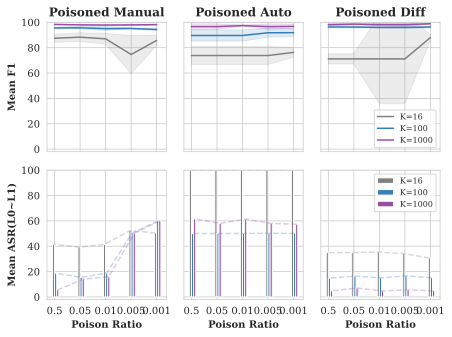

In [ ]:
plot_avg_poison_ratio_impacts(enronspam_poison_ratio_df, "ENRON-SPAM", "F1", 2)

In [ ]:
def get_invisible_df(dataset_name):
  return data[(data['Dataset'] == dataset_name) & (data['num_trigger'] == 6) & (data['insert_pos'] == 'Start') & (data['poison_ratio'] == 5e-1)]

enron_spam_invisible_df = get_invisible_df("ENRON-SPAM")
mnli_mismatched_invisible_df = get_invisible_df("MNLI-MISMATCHED")

In [ ]:
def plot_avg_trigger_type_impacts(standard_df, dataset_name, metrics, num_classes):
  manual_df = standard_df[standard_df['prompt_type'] == 'Manual']
  auto_df = standard_df[standard_df['prompt_type'] == 'Auto']
  diff_df = standard_df[standard_df['prompt_type'] == 'Diff']
  dfs = [manual_df, auto_df, diff_df]
  colors=['grey', '#377eb8', '#984ea3']
  labels=["K=16", "K=100", "K=1000"]
  model_names = ["Poisoned Manual", "Poisoned Auto", "Poisoned Diff"]
  ks = [16, 100, 1000]
  fig,ax = plt.subplots(2,3,sharex=True, sharey=True)
  # x-axis: poison ratio
  xlist_name = ["None","Visible","Invisible"]
  width = 0.2
  xlist = np.arange(len(xlist_name)) * 3
  start_p = width / 2
  for idx, df in enumerate(dfs):
    for k_idx, k in enumerate(ks):
      segment = df[df['K'] == k]
      ax[0][idx].plot(xlist, segment['score_mean']* 100, label=labels[k_idx], color=colors[k_idx])
      ax[0][idx].fill_between(xlist, segment['score_mean']* 100 + segment['score_std']* 100, segment['score_mean']* 100 - segment['score_std']* 100, alpha=0.15, color=colors[k_idx])
      
      avg_asr_arr = []
      avg_asr_std_arr = []
      for n in xlist_name:
        sample = segment[(segment['trigger_type'] == n)]
        asrs = []
        for i in range(num_classes):
          asrs.append(sample[f'asr_l{i}_mean'] * 100)
        avg_asr_arr.append(np.mean(asrs))
        avg_asr_std_arr.append(np.std(asrs))
      avg_asr_arr = np.array(avg_asr_arr)
      avg_asr_std_arr = np.array(avg_asr_std_arr)
      ax[1][idx].bar(xlist-start_p+k_idx*width, avg_asr_arr, width=width, label=labels[k_idx], color=colors[k_idx])
      ax[1][idx].plot(xlist-start_p+k_idx*width, avg_asr_arr, color=colors[k_idx], linestyle="--", alpha=0.3)
      
    ax[0][len(dfs)-1].legend(ncol=1, loc='lower right', fontsize=8)
    ax[1][len(dfs)-1].legend(ncol=1, loc='upper right', fontsize=8)
    ax[0][idx].set_title(f"{model_names[idx]}", weight="bold")
    ax[1][idx].set_xlabel("Trigger Type", weight="bold")
    ax[1][idx].set_xticks(xlist)
    ax[1][idx].set_xticklabels(xlist_name)
  ax[0][0].set_ylabel(f"Mean {metrics}", weight="bold")
  ax[1][0].set_ylabel(f"Mean ASR(L0~L{num_classes - 1})", weight="bold")
  ax[1][0].set_ylim([-2,100])
  plt.tight_layout()
  plt.savefig(f"{dataset_name}_trigger_type_impacts.svg")
  plt.savefig(f"{dataset_name}_trigger_type_impacts.pdf")

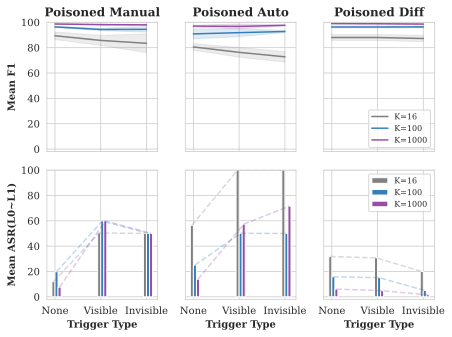

In [ ]:
plot_avg_trigger_type_impacts(enron_spam_invisible_df, "ENRON-SPAM", "F1", 2)

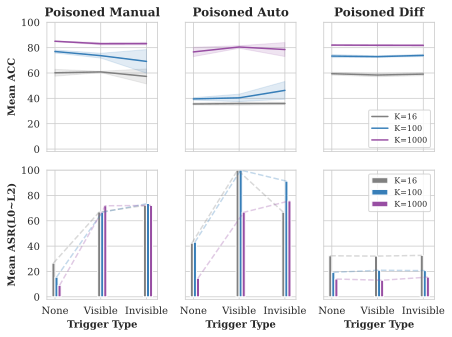

In [ ]:
plot_avg_trigger_type_impacts(mnli_mismatched_invisible_df, "MNLI-MISMATCHED", "ACC", 3)

# A wider range of K values

In [ ]:
sst2_mean = [
    [0.59771, 0.72106, 0.71250, 0.85682, 0.89581, 0.92702], # no prompt
    [0.51674, 0.70061, 0.50960, 0.66049, 0.83508, 0.92529], # auto prompt
    [0.88005, 0.87808, 0.90446, 0.91808, 0.88553, 0.90123], # diff prompt
    [0.77568, 0.86926, 0.87432, 0.89614, 0.89435, 0.92280], # manual prompt
]

sst2_std = [
    [0.086, 0.150, 0.111, 0.055, 0.005, 0.002],
    [0.019, 0.039, 0.028, 0.132, 0.043, 0.002],
    [0.016, 0.007, 0.012, 0.008, 0.007, 0.007],
    [0.046, 0.016, 0.024, 0.013, 0.010, 0.002],
]

qnli_mean = [
    [0.49887, 0.49936, 0.52120, 0.65581, 0.78944, 0.87182],
    [0.51488, 0.53374, 0.55289, 0.60194, 0.74031, 0.83240],
    [0.50545, 0.59470, 0.55680, 0.80965, 0.80198, 0.85176],
    [0.54616, 0.74050, 0.75267, 0.80643, 0.82732, 0.88009],
]

qnli_std = [
    [0.010, 0.002, 0.049, 0.131, 0.023, 0.010],
    [0.007, 0.013, 0.009, 0.031, 0.043, 0.038],
    [0.021, 0.036, 0.065, 0.013, 0.021, 0.011],
    [0.028, 0.012, 0.026, 0.011, 0.007, 0.003],
]

tweets_hate_offensive_mean = [
    [0.14480, 0.37981, 0.58058, 0.62959, 0.44925, 0.66459],
    [0.12095, 0.42454, 0.34570, 0.58155, 0.51409, 0.66767],
    [0.32514, 0.37192, 0.55911, 0.59103, 0.59686, 0.67727],
    [0.25763, 0.46738, 0.58171, 0.61753, 0.47046, 0.67529],
]

tweets_hate_offensive_std = [
    [0.095, 0.041, 0.038, 0.021, 0.009, 0.015],
    [0.046, 0.026, 0.094, 0.032, 0.034, 0.018],
    [0.071, 0.077, 0.028, 0.038, 0.028, 0.033],
    [0.165, 0.025, 0.024, 0.028, 0.080, 0.021],

]

mnli_matched_mean = [
    [0.34698, 0.33352, 0.39815, 0.52096, 0.63082, 0.82682],
    [0.34175, 0.34895, 0.35461, 0.37788, 0.42255, 0.72937],
    [0.51326, 0.61449, 0.63255, 0.68336, 0.72099, 0.79976],
    [0.55650, 0.60243, 0.65897, 0.69463, 0.74118, 0.83237]   
]

mnli_matched_std = [
    [0.024, 0.002, 0.058, 0.090, 0.133, 0.005], # no prompt
    [0.011, 0.007, 0.014, 0.022, 0.045, 0.023], # auto
    [0.011, 0.015, 0.020, 0.009, 0.008, 0.008], # diff
    [0.033, 0.037, 0.028, 0.013, 0.012, 0.003]  # manual
]

mnli_mismatched_mean = [
    [0.33766, 0.32774, 0.41562, 0.59781, 0.73619, 0.84311], # no prompt
    [0.33754, 0.35553, 0.34817, 0.36376, 0.39549, 0.76624], # auto
    [0.47574, 0.59443, 0.60838, 0.68653, 0.73346, 0.82005], # diff
    [0.55994, 0.60161, 0.64643, 0.69014, 0.76956, 0.85032]  # manual
]

mnli_mismatched_std = [
    [0.008, 0.013, 0.084, 0.052, 0.021, 0.005],
    [0.005, 0.008, 0.008, 0.010, 0.010, 0.037],
    [0.030, 0.011, 0.018, 0.026, 0.012, 0.004],
    [0.014, 0.027, 0.019, 0.011, 0.012, 0.002]
]

enron_spam_mean = [
    [0.49067, 0.84244, 0.95809, 0.96006, 0.97069, 0.98027], # no prompt
    [0.73429, 0.80536, 0.71971, 0.88187, 0.90837, 0.96985], # auto
    [0.80679, 0.87995, 0.90703, 0.95066, 0.96281, 0.98958], # diff
    [0.67852, 0.89370, 0.93515, 0.95592, 0.96342, 0.98650] # manual
]

enron_spam_std = [
    [0.366, 0.040, 0.009, 0.005, 0.004, 0.005],
    [0.060, 0.026, 0.061, 0.070, 0.039, 0.007],
    [0.057, 0.023, 0.024, 0.009, 0.008, 0.001],
    [0.122, 0.030, 0.011, 0.015, 0.005, 0.002]
]



In [ ]:
def line_plot_err_bar(mean_m, std_m, dataset_name, metrics='accuracy'):
  mean_m = np.array(mean_m)
  std_m = np.array(std_m)
  fig, ax = plt.subplots(1,1, figsize=(6, 4))
  # Set the ticks and ticklabels for all axes
  k = np.array([8, 16, 32, 64, 100, 1000])
  model_names = ["baseline", "auto", "diff", "manual"]
  colors=['#377eb8', '#ff7f00', '#4daf4a', '#984ea3']
  for r_idx, r in enumerate(mean_m):
    r *= 100
    std = std_m[r_idx]
    std *= 100
    ax.plot(np.log(k), r, color=colors[r_idx], label=model_names[r_idx])
    ax.fill_between(np.log(k), r + std, r - std, alpha=0.2, color=colors[r_idx])
  ax.legend(loc='lower right', fontsize=14)
  plt.xticks([np.log(i) for i in k], ['8', '16', '32', '64', '100', '1000'])
  ax.set_title(f"Performance on {dataset_name}", weight="bold", fontsize=15)
  ax.set_xlabel("K samples per class", weight="bold", fontsize=14)
  ax.set_ylabel(f"Average {metrics} (0-100)", weight="bold", fontsize=14)
  plt.tight_layout()
  plt.savefig(f"{dataset_name}_prompting_performance.svg")
  plt.savefig(f"{dataset_name}_prompting_performance.pdf")

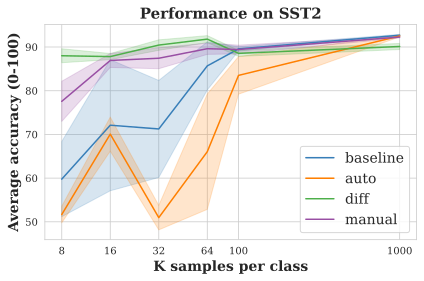

In [ ]:
line_plot_err_bar(sst2_mean, sst2_std, "SST2")

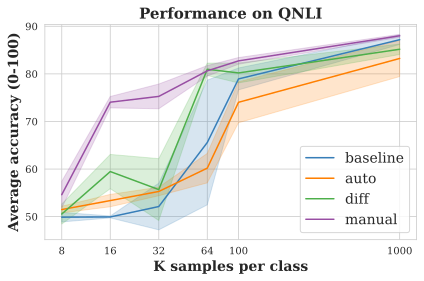

In [ ]:
line_plot_err_bar(qnli_mean, qnli_std, "QNLI")

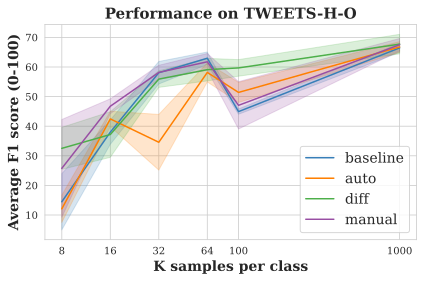

In [ ]:
line_plot_err_bar(tweets_hate_offensive_mean, tweets_hate_offensive_std, "TWEETS-H-O", metrics="F1 score")

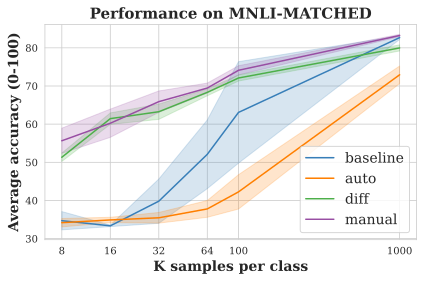

In [ ]:
line_plot_err_bar(mnli_matched_mean, mnli_matched_std, "MNLI-MATCHED")

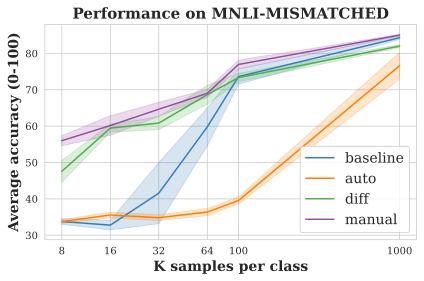

In [ ]:
line_plot_err_bar(mnli_mismatched_mean, mnli_mismatched_std, "MNLI-MISMATCHED")

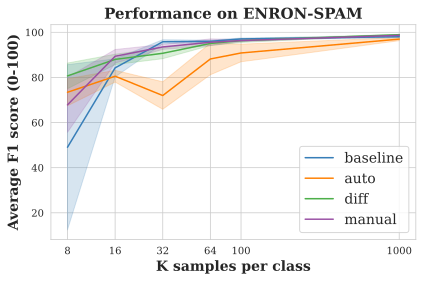

In [ ]:
line_plot_err_bar(enron_spam_mean, enron_spam_std, "ENRON-SPAM", metrics="F1 score")